In [ ]:
import pandas as pd
import numpy as np
import math
from keras.layers import Embedding, Dense, LSTM, Dense, Input, concatenate
from keras.models import Model
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import datetime
from keras.regularizers import l2
from keras.models import load_model
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Stacking all the diffrent types of bot accounts(social spambots 1,social spambots 2,social spam bots 3) into one single Dataframe for easy processing**


In [ ]:
bot_accounts = pd.concat([pd.read_csv('/content/drive/MyDrive/SAAS-2121/Datasets/account_level dataset/users 1.csv'),
                          pd.read_csv('/content/drive/MyDrive/SAAS-2121/Datasets/account_level dataset/users 2.csv'), 
                          pd.read_csv('/content/drive/MyDrive/SAAS-2121/Datasets/account_level dataset/users 3.csv')]).reset_index(drop=True)

In [ ]:
bot_accounts.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,time_zone,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_text_color,profile_image_url_https,profile_sidebar_border_color,profile_background_tile,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,description,contributors_enabled,following,created_at,timestamp,crawled_at,updated,test_set_1,test_set_2
0,24858289,Davide Bertoli,davideb66,1299,22,40,1,0,NaN,it,Rome,NaN,1.0,1.0,1.0,http://abs.twimg.com/sticky/default_profile_im...,NaN,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://abs.twimg.com/sticky/default_profile_i...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,7200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tue Mar 17 08:51:12 +0000 2009,2009-03-17 09:51:12,2014-04-19 14:46:19,2016-03-15 14:12:22,1.0,NaN
1,33212890,Elisa D'Ospina,ElisaDospina,18665,12561,3442,16358,110,http://t.co/ceK8TovxwI,it,Greenland,Italy,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/2603147033...,https://pbs.twimg.com/profile_banners/33212890...,1.0,https://pbs.twimg.com/profile_background_image...,333333,https://pbs.twimg.com/profile_images/260314703...,FFFFFF,1.0,F3F3F3,http://pbs.twimg.com/profile_background_images...,EBEBEB,990000,-7200.0,NaN,NaN,NaN,NaN,NaN,Autrice del libro #unavitatuttacurve dal 9 apr...,NaN,NaN,Sun Apr 19 14:38:04 +0000 2009,2009-04-19 16:38:04,2014-05-18 23:20:58,2016-03-15 14:17:13,1.0,NaN
2,39773427,Donato Vincenzo,Vladimir65,22987,600,755,14,6,NaN,it,Rome,"iPhone: 45.471680,9.192429",NaN,NaN,NaN,http://pbs.twimg.com/profile_images/2290354446...,https://pbs.twimg.com/profile_banners/39773427...,1.0,https://pbs.twimg.com/profile_background_image...,333333,https://pbs.twimg.com/profile_images/229035444...,FFFFFF,1.0,EFEFEF,http://pbs.twimg.com/profile_background_images...,131516,009999,7200.0,NaN,NaN,NaN,NaN,NaN,[Live Long and Prosper],NaN,NaN,Wed May 13 15:34:41 +0000 2009,2009-05-13 17:34:41,2014-05-13 23:21:54,2016-03-15 14:16:44,1.0,NaN
3,57007623,Rafiela Morales L.,RafielaMorales,7975,398,350,11,2,NaN,en,Pacific Time (US & Canada),"ÜT: 18.4698712,-69.9327525",NaN,NaN,NaN,http://pbs.twimg.com/profile_images/3788000008...,https://pbs.twimg.com/profile_banners/57007623...,1.0,https://pbs.twimg.com/profile_background_image...,3E4415,https://pbs.twimg.com/profile_images/378800000...,829D5E,1.0,8BC712,http://pbs.twimg.com/profile_background_images...,E60584,4BC90C,-25200.0,NaN,NaN,NaN,NaN,NaN,"Cuasi Odontologa*♥,#Bipolar, #Sarcastica & Som...",NaN,NaN,Wed Jul 15 12:55:03 +0000 2009,2009-07-15 14:55:03,2014-05-19 23:24:18,2016-03-15 14:18:54,1.0,NaN
4,63258466,§ h a † u r♄,FabrizioC_c,20218,413,405,162,8,http://t.co/PK5F0JDKcy,it,Rome,Firenze,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/4633019422...,https://pbs.twimg.com/profile_banners/63258466...,1.0,https://pbs.twimg.com/profile_background_image...,D67345,https://pbs.twimg.com/profile_images/463301942...,16471D,NaN,DFF0EF,http://pbs.twimg.com/profile_background_images...,EBEBEB,000000,7200.0,NaN,NaN,NaN,NaN,NaN,"I shall rise from my own death, to avenge hers...",NaN,NaN,Wed Aug 05 21:12:49 +0000 2009,2009-08-05 23:12:49,2014-05-11 23:22:23,2016-03-15 14:17:05,1.0,NaN


In [ ]:
bot_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4912 entries, 0 to 4911
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  4912 non-null   int64  
 1   name                                4912 non-null   object 
 2   screen_name                         4912 non-null   object 
 3   statuses_count                      4912 non-null   int64  
 4   followers_count                     4912 non-null   int64  
 5   friends_count                       4912 non-null   int64  
 6   favourites_count                    4912 non-null   int64  
 7   listed_count                        4912 non-null   int64  
 8   url                                 285 non-null    object 
 9   lang                                4912 non-null   object 
 10  time_zone                           1220 non-null   object 
 11  location                            812 non

# **Loading genuine account level data**

In [ ]:
clean_accounts = pd.read_csv('/content/drive/MyDrive/SAAS-2121/Datasets/account_level dataset/genuine.csv')

In [ ]:
clean_accounts.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,time_zone,location,default_profile,default_profile_image,geo_enabled,profile_image_url,profile_banner_url,profile_use_background_image,profile_background_image_url_https,profile_text_color,profile_image_url_https,profile_sidebar_border_color,profile_background_tile,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,utc_offset,is_translator,follow_request_sent,protected,verified,notifications,description,contributors_enabled,following,created_at,timestamp,crawled_at,updated,test_set_1,test_set_2
0,1502026416,TASUKU HAYAKAWA,0918Bask,2177,208,332,265,1,NaN,ja,NaN,Tokyo .Japan .,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5887331863...,https://pbs.twimg.com/profile_banners/15020264...,NaN,https://abs.twimg.com/images/themes/theme1/bg.png,000000,https://pbs.twimg.com/profile_images/588733186...,000000,NaN,000000,http://abs.twimg.com/images/themes/theme1/bg.png,000000,EB0C1F,NaN,NaN,NaN,NaN,NaN,NaN,15years ago X.Lines24,NaN,NaN,Tue Jun 11 11:20:35 +0000 2013,2013-06-11 13:20:35,2015-05-02 06:41:46,2016-03-15 15:53:47,0,0
1,2492782375,ro_or,1120Roll,2660,330,485,3972,5,NaN,ja,Tokyo,神奈川県横浜市,1.0,NaN,1.0,http://pbs.twimg.com/profile_images/5737442928...,https://pbs.twimg.com/profile_banners/24927823...,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/573744292...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,32400.0,NaN,NaN,NaN,NaN,NaN,保守見習い地元大好き人間。 経済学、電工、仏教を勉強中、ちなDeではいかんのか？ (*^◯^*),NaN,NaN,Tue May 13 10:37:57 +0000 2014,2014-05-13 12:37:57,2015-05-01 17:20:27,2016-03-15 15:53:48,0,0
2,293212315,bearclaw,14KBBrown,1254,166,177,1185,0,NaN,en,Eastern Time (US & Canada),NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5908597242...,https://pbs.twimg.com/profile_banners/29321231...,1.0,https://pbs.twimg.com/profile_background_image...,0F9A89,https://pbs.twimg.com/profile_images/590859724...,EED96D,1.0,EED96D,http://pbs.twimg.com/profile_background_images...,E63A50,E63A50,-14400.0,NaN,NaN,NaN,NaN,NaN,Let me see what your best move is!,NaN,NaN,Wed May 04 23:30:37 +0000 2011,2011-05-05 01:30:37,2015-05-01 18:48:28,2016-03-15 15:53:48,0,0
3,191839658,pocahontas farida,wadespeters,202968,2248,981,60304,101,http://t.co/rGV0HIJGsu,en,Greenland,#freePalestine - rip paul,NaN,NaN,1.0,http://pbs.twimg.com/profile_images/5915979249...,https://pbs.twimg.com/profile_banners/19183965...,1.0,https://abs.twimg.com/images/themes/theme3/bg.gif,634047,https://pbs.twimg.com/profile_images/591597924...,D3D2CF,NaN,E3E2DE,http://abs.twimg.com/images/themes/theme3/bg.gif,EDECE9,088253,-7200.0,NaN,NaN,NaN,NaN,NaN,20. menna: #farida #nyc and the 80s actually y...,NaN,NaN,Fri Sep 17 14:02:10 +0000 2010,2010-09-17 16:02:10,2015-05-01 13:55:16,2016-03-15 15:53:48,0,0
4,3020965143,Ms Kathy,191a5bd05da04dc,82,21,79,5,0,NaN,en,NaN,Wichita KS,1.0,NaN,NaN,http://pbs.twimg.com/profile_images/5635511026...,NaN,1.0,https://abs.twimg.com/images/themes/theme1/bg.png,333333,https://pbs.twimg.com/profile_images/563551102...,C0DEED,NaN,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,NaN,NaN,NaN,NaN,NaN,NaN,Cosmetologist,NaN,NaN,Fri Feb 06 04:10:49 +0000 2015,2015-02-06 05:10:49,2015-05-02 01:17:32,2016-03-15 15:53:48,0,0


In [ ]:
clean_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  3474 non-null   int64  
 1   name                                3473 non-null   object 
 2   screen_name                         3474 non-null   object 
 3   statuses_count                      3474 non-null   int64  
 4   followers_count                     3474 non-null   int64  
 5   friends_count                       3474 non-null   int64  
 6   favourites_count                    3474 non-null   int64  
 7   listed_count                        3474 non-null   int64  
 8   url                                 1266 non-null   object 
 9   lang                                3474 non-null   object 
 10  time_zone                           2475 non-null   object 
 11  location                            2365 no

# **Feature selection for bot accounts and genuine accounts** 

In [ ]:
selected_cols = ['screen_name', 'created_at', 'updated', 'location', 'verified', 'statuses_count', 'friends_count','followers_count', 'favourites_count', 'default_profile_image', 'profile_use_background_image', 'protected', 'default_profile']
bot_accounts = bot_accounts[selected_cols]
clean_accounts = clean_accounts[selected_cols]

# **preprocessing of the dataframes**

In [ ]:
def clean_df(df):
    df['created_at'] = pd.to_datetime(df['created_at'],utc=True)
    df['updated'] = pd.to_datetime(df['updated'],utc=True)
    df['age'] = (df['updated'] - df['created_at']).astype('timedelta64[D]').astype(int)
    df['has_location'] = df['location'].apply(lambda x: 0 if x==x else 1)
    df['has_avatar'] = df['default_profile_image'].apply(lambda x: 1 if x==x else 0)
    df['has_background'] = df['profile_use_background_image'].apply(lambda x: 1 if x==x else 0)
    df['is_verified']=df['verified'].apply(lambda x: 1 if x==x else 0)
    df['is_protected']=df['protected'].apply(lambda x: 1 if x==x else 0)
    df['profile_modified'] = df['default_profile'].apply(lambda x: 0 if x==x else 1)
    df = df.rename(index=str, columns={"screen_name": "username", "statuses_count": "total_tweets", "friends_count": "total_following", "followers_count": "total_followers", "favourites_count": "total_likes"})
    return df[['username', 'age', 'has_location', 'is_verified', 'total_tweets', 'total_following', 'total_followers', 'total_likes', 'has_avatar', 'has_background', 'is_protected', 'profile_modified']]

bot_accounts = clean_df(bot_accounts)
clean_accounts = clean_df(clean_accounts)

# **Updated dataframes**

In [ ]:
bot_accounts.head()

,username,age,has_location,is_verified,total_tweets,total_following,total_followers,total_likes,has_avatar,has_background,is_protected,profile_modified
0,davideb66,2555,1,0,1299,40,22,1,1,1,0,0
1,ElisaDospina,2521,0,0,18665,3442,12561,16358,0,1,0,1
2,Vladimir65,2497,0,0,22987,755,600,14,0,1,0,1
3,RafielaMorales,2435,0,0,7975,350,398,11,0,1,0,1
4,FabrizioC_c,2413,0,0,20218,405,413,162,0,1,0,1


In [ ]:
clean_accounts.head()

,username,age,has_location,is_verified,total_tweets,total_following,total_followers,total_likes,has_avatar,has_background,is_protected,profile_modified
0,0918Bask,1008,0,0,2177,332,208,265,0,0,0,1
1,1120Roll,672,0,0,2660,485,330,3972,0,1,0,0
2,14KBBrown,1776,1,0,1254,177,166,1185,0,1,0,1
3,wadespeters,2006,0,0,202968,981,2248,60304,0,1,0,1
4,191a5bd05da04dc,403,0,0,82,79,21,5,0,1,0,0


# **Encoding binary values to Bot or Not accounts**

In [ ]:
bot_accounts['BotOrNot'] = 1
clean_accounts['BotOrNot'] = 0

combined_df = pd.concat([bot_accounts, clean_accounts])

new_df = combined_df.sample(frac=1).reset_index(drop=True)

# **Standardization of attributes and train test split**

In [ ]:
training_df = new_df.drop('username', axis=1)[:int(combined_df.shape[0] * 0.8)]
test_df = new_df.drop('username', axis=1)[int(combined_df.shape[0] * 0.8):]

columns_to_standardize = ['age', 'total_tweets', 'total_following', 'total_followers', 'total_likes']

training_df_mean = training_df[columns_to_standardize].mean()
training_df_std = training_df[columns_to_standardize].std()

training_df[columns_to_standardize] = (training_df[columns_to_standardize] - training_df_mean)/training_df_std
test_df[columns_to_standardize] = (test_df[columns_to_standardize] - training_df_mean)/training_df_std

In [ ]:
X_train = training_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_train = training_df['BotOrNot'].values.reshape(-1,1)

X_test = test_df.drop(['BotOrNot', 'is_protected'], axis=1).values
y_test = test_df['BotOrNot'].values.reshape(-1,1)

In [ ]:
X_test[0]

array([ 0.82868672,  1.        ,  0.        ,  0.20498027,  0.28777462,
       -0.01814796, -0.24477836,  0.        ,  1.        ,  1.        ])

# **Stacking layers to the model**

In [ ]:
inp = Input(shape=[10])
another = Dense(500, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(inp)
another = Dense(200, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(another)
another = Dense(1, activation='sigmoid')(another)
mod = Model(inp, another)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# **Model Training**

In [ ]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
training = mod.fit(x=X_train, y=y_train, batch_size=64, epochs=40, validation_data=(X_test, y_test),callbacks=[tensorboard_callback])

Epoch 1/40
105/105 [==============================] - 2s 8ms/step - loss: 1.2735 - accuracy: 0.8699 - val_loss: 0.4104 - val_accuracy: 0.9291
Epoch 2/40
105/105 [==============================] - 1s 6ms/step - loss: 0.3509 - accuracy: 0.9341 - val_loss: 0.3299 - val_accuracy: 0.9356
Epoch 3/40
105/105 [==============================] - 1s 6ms/step - loss: 0.3077 - accuracy: 0.9366 - val_loss: 0.2887 - val_accuracy: 0.9249
Epoch 4/40
105/105 [==============================] - 1s 6ms/step - loss: 0.2838 - accuracy: 0.9439 - val_loss: 0.2760 - val_accuracy: 0.9452
Epoch 5/40
105/105 [==============================] - 1s 6ms/step - loss: 0.2681 - accuracy: 0.9453 - val_loss: 0.2557 - val_accuracy: 0.9422
Epoch 6/40
105/105 [==============================] - 1s 6ms/step - loss: 0.2569 - accuracy: 0.9502 - val_loss: 0.2968 - val_accuracy: 0.9118
Epoch 7/40
105/105 [==============================] - 1s 6ms/step - loss: 0.2514 - accuracy: 0.9477 - val_loss: 0.2387 - val_accuracy: 0.9529
Epoch 

# **Model Summary**

In [ ]:
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 500)               5500      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 105,901
Trainable params: 105,901
Non-trainable params: 0
_________________________________________________________________


# **Visuialisation of the feed-forward neural network**

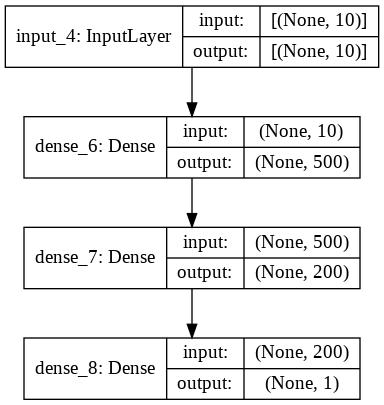

In [ ]:
from keras.utils import plot_model
plot_model(mod, to_file='feed_forward.png', show_shapes=True, show_layer_names=True)

# **Evaluation of the model**

In [ ]:
score = mod.evaluate(X_test, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.155473530292511
Test accuracy: 0.9678188562393188


In [ ]:
import sklearn

In [ ]:
y_pred = mod.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))

In [ ]:
print(confusion_matrix)

[[644  36]
 [ 18 980]]


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
list(zip(mod.predict(X_test).flatten(),y_test.flatten()))

[(0.08535847, 0),
 (0.89740056, 1),
 (0.015844613, 0),
 (0.98637354, 1),
 (0.9869453, 1),
 (0.42040065, 1),
 (0.0018847287, 0),
 (0.9873251, 1),
 (0.9865706, 1),
 (0.23740023, 0),
 (0.9866015, 1),
 (0.0008470416, 0),
 (0.9871439, 1),
 (0.018342853, 0),
 (0.89629036, 1),
 (0.0006438494, 0),
 (0.010596514, 0),
 (0.9872376, 1),
 (0.9873169, 1),
 (0.9870068, 1),
 (0.9871627, 1),
 (0.98708, 1),
 (4.430618e-05, 0),
 (0.91143525, 1),
 (0.6145887, 1),
 (0.9870829, 1),
 (0.02553457, 0),
 (0.98767895, 1),
 (0.9871675, 1),
 (0.9870882, 1),
 (0.000610739, 0),
 (0.9872179, 1),
 (0.9868536, 1),
 (0.0012591481, 0),
 (0.13686323, 0),
 (0.12194842, 0),
 (0.00041267276, 0),
 (0.90845156, 1),
 (0.95518625, 1),
 (0.0016133487, 0),
 (0.98683786, 1),
 (0.009890646, 0),
 (0.966009, 1),
 (0.9869556, 1),
 (0.023410708, 0),
 (0.7412479, 1),
 (0.06588635, 0),
 (0.9050053, 1),
 (0.005943209, 0),
 (0.9871277, 1),
 (0.98714596, 1),
 (0.98727524, 1),
 (0.11000806, 0),
 (0.006523758, 0),
 (0.011488736, 0),
 (0.006008

# **Saving and loading model in .h5 format**

In [ ]:
mod.save("account_level.h5")
new_model = load_model('account_level.h5')

In [ ]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 105,901
Trainable params: 105,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['genuine accounts', 'social spambots #1','social spambots #2','social spambots #3', 'traditional spambots #1', 'traditional spambots #2','traditional spambots #3','traditional spambots #4','fake followers']
students = [3474,991,3457,464,1000,100,433,1128,3351]
ax.bar(langs,students)
plt.xticks(rotation=90)
plt.ylabel('number of accounts')
plt.show()

from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['genuine twitter users in the dataset','Bot accounts in the dataset']
students = [3474,10924]
explode = (0, 0.2)
ax.pie(students,explode=explode, labels = langs,autopct='%1.2f%%',shadow=True)
plt.show()